# Geopandas: MT data from EDI Files 
    *  How to concatenate multiple geopandas frames?
    *  How to chnage the geometry crs
    *  how to display on a basemap
    *  how to display on folium map


## http://geopandas.org/index.html
## https://geohackweek.github.io/vector/04-geopandas-intro/
## https://pythongisresources.wordpress.com/packages/


GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

In [2]:
import os,sys
import glob
import csv
import numpy as np
import pandas as pd
import geopandas as gpd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'

mpl.rcParams['figure.figsize']=[30,10]

# Create Geo-database of MT Surveys datasets


1) walk through all edi files

2) get lat lon, station name, etc.

3) create csv, export to shapefile


In [3]:
import mtpy.imaging.penetration_depth_3d_profile as pen3d

INFO:root:module file: /e/Githubz/mtpy2/mtpy/utils/mtpylog.pyc
INFO:root:Effective yaml configuration file /e/Githubz/mtpy2/mtpy/utils/logging.yml


Note: need scipy version 0.14.0 or higher or interpolation might not work.


In [4]:

def process_edifiles(edi_files):
    """loop over all edi files to extract relevant properties from each edifile:
        lat, lon, elev, station_name, acquisition_date, ....... 
    """
    
    PER_LIST0=None   # the first period list as a reference for checking other stations period
    latlon_dep=[]  # CSV to be returned
    for afile in edi_files:
        # for efile in edi_files[:2]:
#         logger.debug("processing %s", afile)
        lat,lon, per, depths=pen3d.get_penetration_depths_from_edi_file(afile)
        if PER_LIST0 is None:
            PER_LIST0=per # initial value assignment
            depth_string = ','.join(['%.2f' % num for num in depths])
            latlon_dep.append((lat, lon, depth_string))

        elif len(per)== len(PER_LIST0) and (per == PER_LIST0).all():  # same length and same values.
            depth_string = ','.join(['%.2f' % num for num in depths])
            latlon_dep.append((lat,lon, depth_string))
        else:
            #logger.warn("MT Periods Not Equal !! %s VS %s", per, PER_LIST0 )
            pass

    return latlon_dep



In [5]:

EDI_DIR="/e/Data/MT_Datasets/GA_UA_edited_10s-10000s"  #'/Softlab/Data/MT_datasets/728889/EDI_files'
#EDI_DIR='E:/Datasets/MT_Datasets/75098/EDI_files' #'E:/Datasets/MT_Datasets/728889/EDI_files'
#EDI_DIR='/g/data/ha3/fxz547/Githubz/mtpy2/tests/data/edifiles/'

edi_files = glob.glob(os.path.join(EDI_DIR, "*.edi"))

if (len(edi_files)<1):
    raise Exception("No edi files found!!!")
    
lat_lon_depth=process_edifiles(edi_files)

Exception: No edi files found!!!

In [ ]:

mypdf=pd.DataFrame(lat_lon_depth)

In [ ]:
mypdf.head()

In [ ]:
history(mypdf.rename())

In [ ]:
mypdf.rename(columns={0: 'lat', 1: 'lon', 2: 'pendepths'}, inplace=True)

In [ ]:
mypdf.head()

In [ ]:
mypdf.shape

In [ ]:
from shapely.geometry import Point

# combine lat and lon column to a shapely Point() object
mypdf['geometry'] = mypdf.apply(lambda x: Point((float(x[1]), float(x[0]))), axis=1)

In [ ]:
crs0 = {'init': 'epsg:4283'}  # GGA94
mygdf = gpd.GeoDataFrame(mypdf, crs=crs0, geometry='geometry')

In [ ]:
mygdf.head()

In [ ]:

#mygdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

mt_survey_loc_shp = os.path.join(EDI_DIR,'mt_survey_sites.shp') 
mygdf.to_file(mt_survey_loc_shp, driver='ESRI Shapefile')

In [ ]:
print mt_survey_loc_shp

In [ ]:
!fio info /g/data/ha3/fxz547/Githubz/mtpy2/tests/data/edifiles/mt_survey_sites.shp

# Read in shape file and plot it

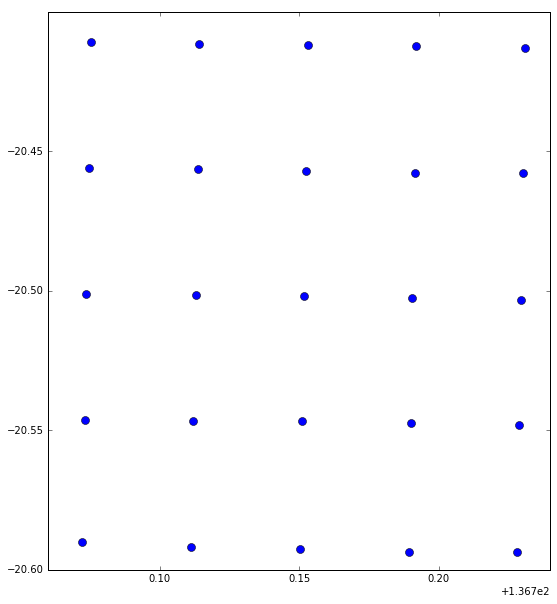

In [9]:
myshape='/e/tmp/edi_collection_test.shp'

mygdf=gpd.read_file(myshape)
mygdf.plot(marker='o', markersize=8, color='b')


In [43]:
mygdf.head()

,Elev,Lat,Lon,StationId,UtmZone,geometry
0,145.0,-20.592444,136.850222,IEB114-014A,53K,POINT (136.8502222222222 -20.59244444444444)
1,146.0,-20.593472,136.889194,IEB114-016A,53K,POINT (136.8891944444444 -20.59347222222222)
2,156.0,-20.457833,136.891444,IEB114-316A,53K,POINT (136.8914444444444 -20.45783333333333)
3,154.0,-20.412278,136.891806,IEB114-416A,53K,POINT (136.8918055555555 -20.41227777777778)
4,150.0,-20.502694,136.890528,IEB114-216A,53K,POINT (136.8905277777778 -20.50269444444444)


In [10]:
mygdf.crs

{u'ellps': u'GRS80', u'no_defs': True, u'proj': u'longlat'}

In [13]:
mygdf.total_bounds

(136.77222222222224,
 -20.593694444444445,
 136.93077777777776,
 -20.41086111111111)

In [14]:
mygdf2=mygdf.to_crs({'init':'epsg:28355'}) 
# WGS84: 'epsg:4326'

# GDA94:  EPSG:4283 See  http://epsg.io/4283

#http://spatialreference.org/ref/epsg/4283/


In [15]:
mygdf2.crs

{'init': 'epsg:28355'}

In [16]:
mygdf2utm=mygdf2.to_crs({'init':'epsg:28355'}) 

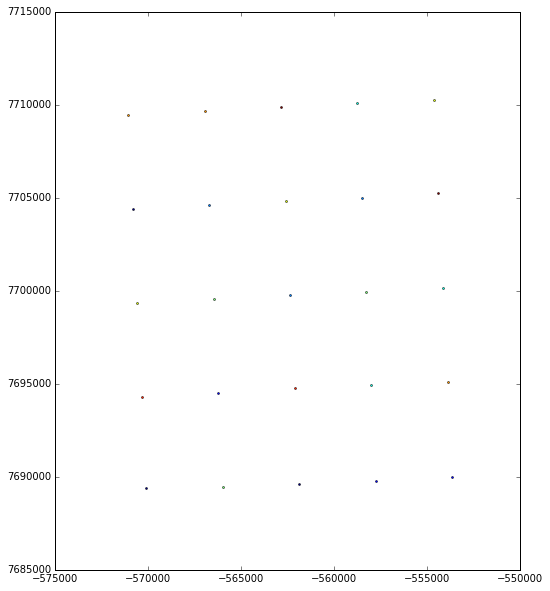

In [17]:
mygdf2utm.plot()

In [18]:
mygdf2utm.crs

{'init': 'epsg:28355'}

In [19]:
mygdf2utm.head()

,Elev,Lat,Lon,StationId,UtmZone,geometry
0,145.0,-20.592444,136.850222,IEB114-014A,53K,POINT (-561899.8102341036 7689631.721500099)
1,146.0,-20.593472,136.889194,IEB114-016A,53K,POINT (-557782.9405837439 7689774.932127886)
2,156.0,-20.457833,136.891444,IEB114-316A,53K,POINT (-558495.3289855693 7704979.078173862)
3,154.0,-20.412278,136.891806,IEB114-416A,53K,POINT (-558774.8094649978 7710083.017176427)
4,150.0,-20.502694,136.890528,IEB114-216A,53K,POINT (-558278.6248578199 7699949.293854536)


# Mapping with Folium

(or Google map, ESRI ArcGIS online)

In [20]:
# conda/pip install folium geojson
# https://github.com/python-visualization/folium


import folium

mapa = folium.Map([-30.0, 149.0], zoom_start=4,   tiles='cartodbpositron')


In [21]:
myshpf = mygdf.set_geometry('geometry')
myshp2json=myshpf.geometry.to_json()

points =folium.features.GeoJson(myshp2json)
mapa.add_children(points)

In [22]:
geoj2=myshpf.to_crs(epsg=4326).to_json()

points2 =folium.features.GeoJson(geoj2)
mapa.add_children(points2)

# Reading Shape files

# Analyze and visualize the geodata

In [23]:
# #shpfile=r'E:\MT_shape_files\PT_0.8547s_WGS84.shp'
# shpfile=r'/Softlab/Data/MT_datasets/75099_Youanmi/Phase_Tensor_Shapes/PT_109.23s_WGS84.shp'
# shpfile=r'/Softlab/Data/MT_datasets/75098/Location_shapefile/YOM_MT_CDP.shp'

shapefile_list=[
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB2.shp",
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB1.shp",
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YML.shp",
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YNB3.shp",
    "/Softlab/Data/MT_Datasets/75098/Location_shapefile/YOM_MT_CDP.shp"
    ]

shp_list=[]
for shpfile in shapefile_list:
    print ("Processing shape file: %s",shpfile)

    shp_gpd=gpd.GeoDataFrame.from_file(shpfile)
    shp_list.append(shp_gpd)

    print(shp_gpd.shape, shp_gpd.columns)
    print("Projection: ", shp_gpd.crs)


('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB2.shp')
((54, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object'))
('Projection: ', {u'no_defs': True, u'ellps': u'GRS80', u'proj': u'longlat'})
('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB1.shp')
((59, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object'))
('Projection: ', {u'no_defs': True, u'ellps': u'GRS80', u'proj': u'longlat'})
('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YML.shp')
((49, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object'))
('Projection: ', {u'no_defs': True, u'ellps': u'GRS80', u'proj': u'longlat'})
('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YNB3.shp')
((22, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'

In [24]:


# the first 3 shape files are of the same structure, they can be joined well:
rdf = gpd.GeoDataFrame( pd.concat( shp_list[:3], ignore_index=True) )

# if include the 4'th shapoe file, which has different columns, the concat will produce a many more columns gpd!!!!!

In [25]:
rdf.shape

(162, 5)

In [26]:
rdf.columns

Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object')

In [27]:
rdf.head()

,Altitude,Latitude,Longitude,Site,geometry
0,463.0,-27.89623,120.84460,YMB141,POINT (120.8446 -27.896233)
1,431.0,-28.27168,118.31708,YMB062,POINT (118.31708 -28.271683)
2,434.0,-28.23312,118.33012,YMB063,POINT (118.33012 -28.233117)
3,445.0,-28.20348,118.31773,YMB064,POINT (118.31773 -28.203483)
4,455.0,-28.16203,118.32352,YMB065,POINT (118.32352 -28.162033)


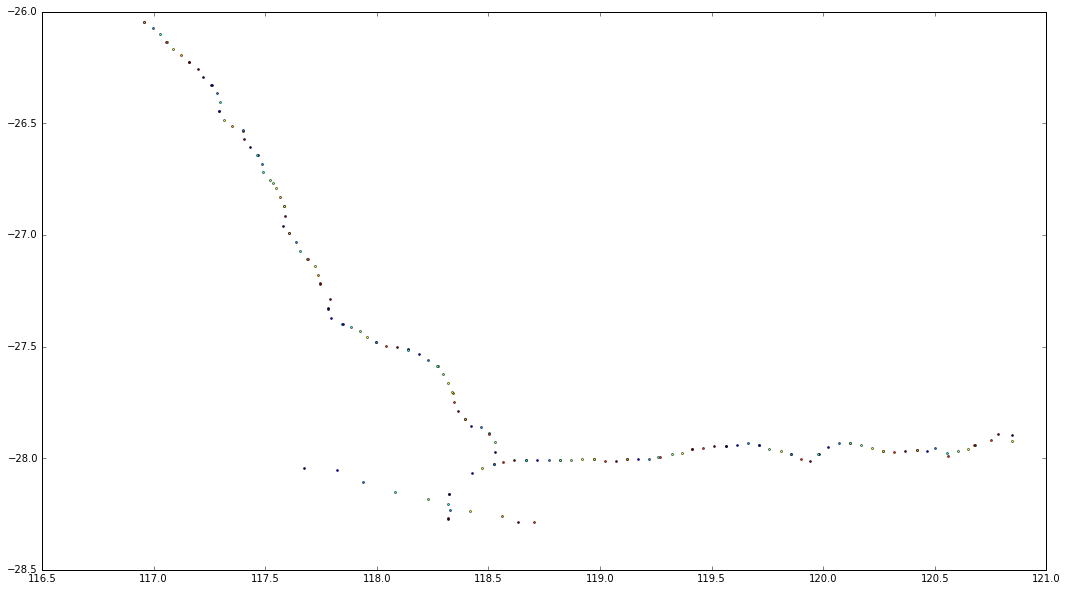

In [28]:
rdf.plot()

In [29]:

icount=4

shpf=shp_list[ icount ]

shpf.head()


,CDP_NO,FID_1,ID,POINT_NO,X,X_E,Y,Y_N,geometry
0,2000,None,BL01,1000,128.27279,426381,-25.04820,7229571,POINT (128.27279 -25.0482)
1,2500,None,B02,1250,128.17672,416971,-25.06974,7227080,POINT (128.17672 -25.06974)
2,3000,None,BL03,1500,128.11526,410585,-25.13284,7219968,POINT (128.11526 -25.13284)
3,3500,None,B04,1750,128.04230,403514,-25.19512,7213107,POINT (128.0423 -25.19512)
4,4000,None,BL05,2000,127.97280,396490,-25.25565,7206423,POINT (127.9728 -25.25565)


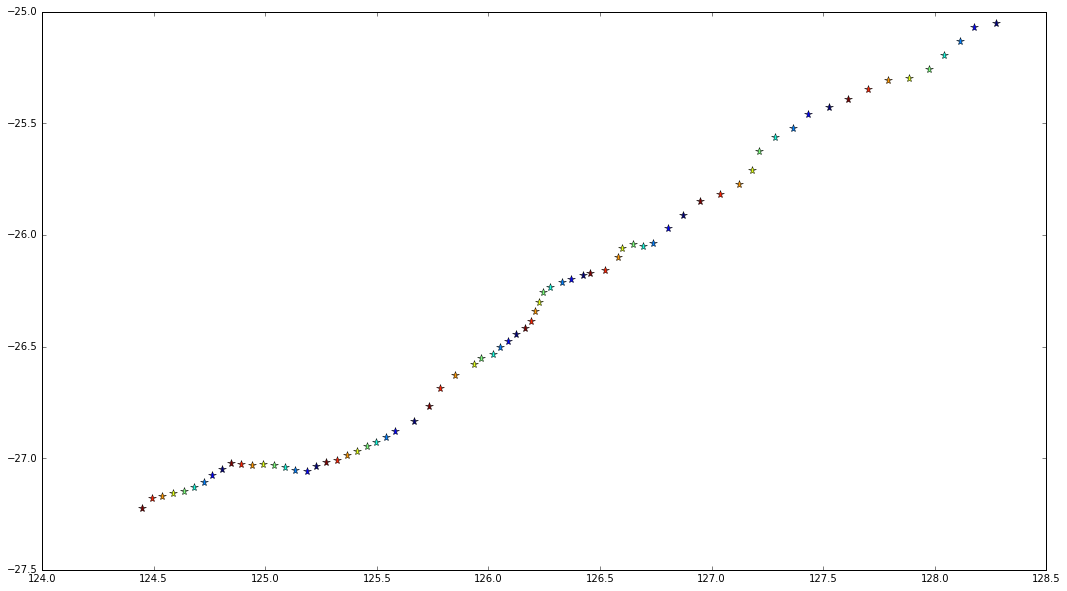

In [30]:
shpf.plot(marker='*', markersize=8)


# Re-Projecting

In [31]:
shpf.geometry.crs

{u'ellps': u'GRS80', u'no_defs': True, u'proj': u'longlat'}

In [32]:
# WGS84: 'epsg:4326'

# GDA94:  EPSG:4283 See  http://epsg.io/4283

#http://spatialreference.org/ref/epsg/4283/
    
myshpf= shpf.to_crs({'init':'epsg:4283'}) 


In [33]:
myshpf.geometry.crs

{'init': 'epsg:4283'}

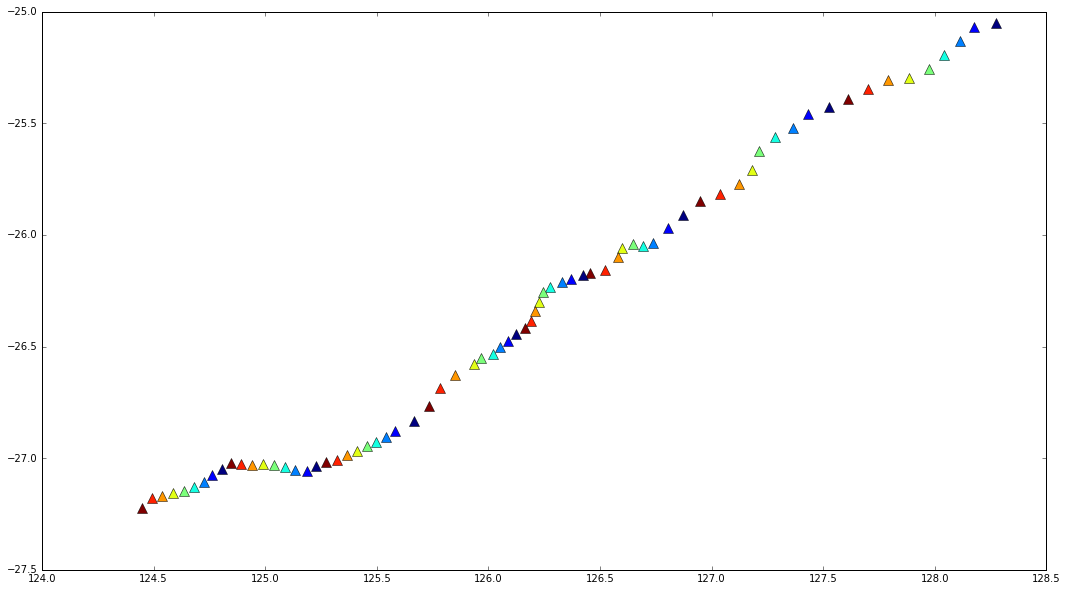

In [34]:
myshpf.plot(marker='^', markersize=10)


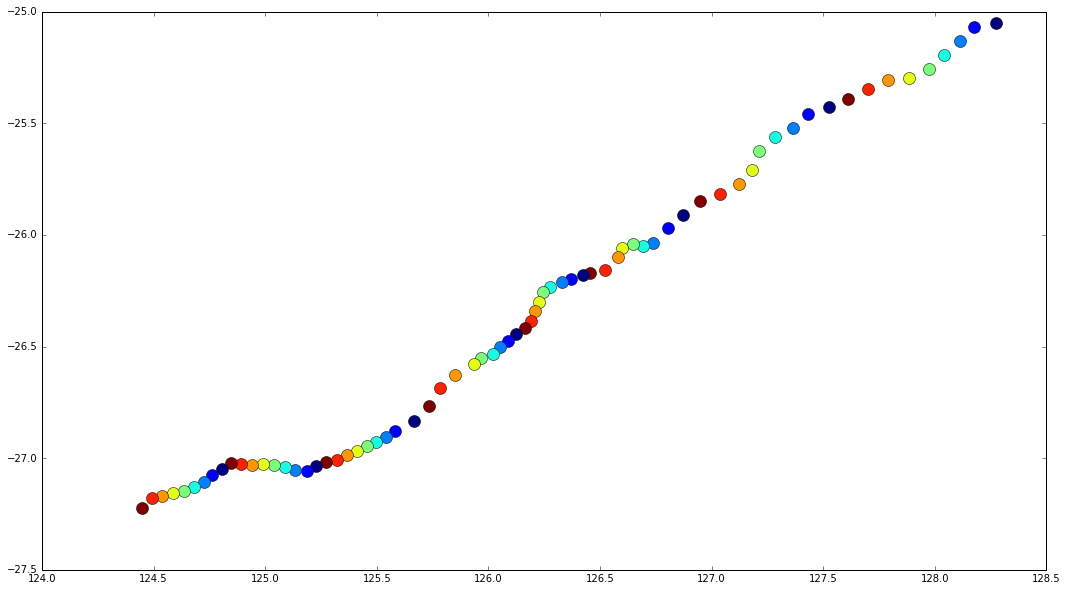

In [35]:
# Now, we create centroids and make it the geometry:

myshpf['centroid_column'] =myshpf.centroid

myshpf = myshpf.set_geometry('centroid_column')

myshpf.plot(marker='o', markersize='12');

In [36]:
myshpf.iloc[-2:]

,CDP_NO,FID_1,ID,POINT_NO,X,X_E,Y,Y_N,geometry,centroid_column
70,25446,None,B72,12940,124.49425,647747,-27.17930,6992656,POINT (124.49425 -27.1793),POINT (124.49425 -27.1793)
71,25600,None,BL73,13105,124.44778,642652,-27.22293,6987644,POINT (124.44778 -27.22293),POINT (124.44778 -27.22293)


In [37]:
myshpf['geometry'][:10]

0     POINT (128.27279 -25.0482)
1    POINT (128.17672 -25.06974)
2    POINT (128.11526 -25.13284)
3     POINT (128.0423 -25.19512)
4     POINT (127.9728 -25.25565)
5    POINT (127.88555 -25.29591)
6    POINT (127.78885 -25.30696)
7    POINT (127.70198 -25.34453)
8    POINT (127.61269 -25.39045)
9    POINT (127.52538 -25.42702)
Name: geometry, dtype: object

## Mapping onto World Basemap

In [38]:
# geopandas included shape datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.shape

(177, 6)

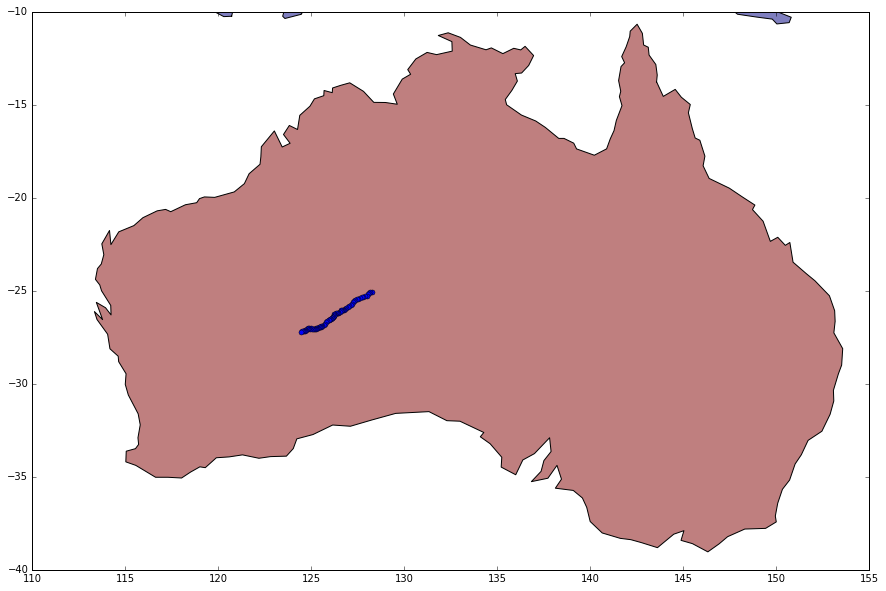

In [39]:


myax=world.plot(alpha=0.5)
#myax.set_xlim([149,150])
myax.set_xlim([110,155])
myax.set_ylim([-40,-10])
    
myax=myshpf.plot(ax=myax, figsize=(10, 6),  marker='o', color='blue', markersize=5);

In [40]:
# what if the crs are different in layers.
world.crs

{'init': u'epsg:4326'}

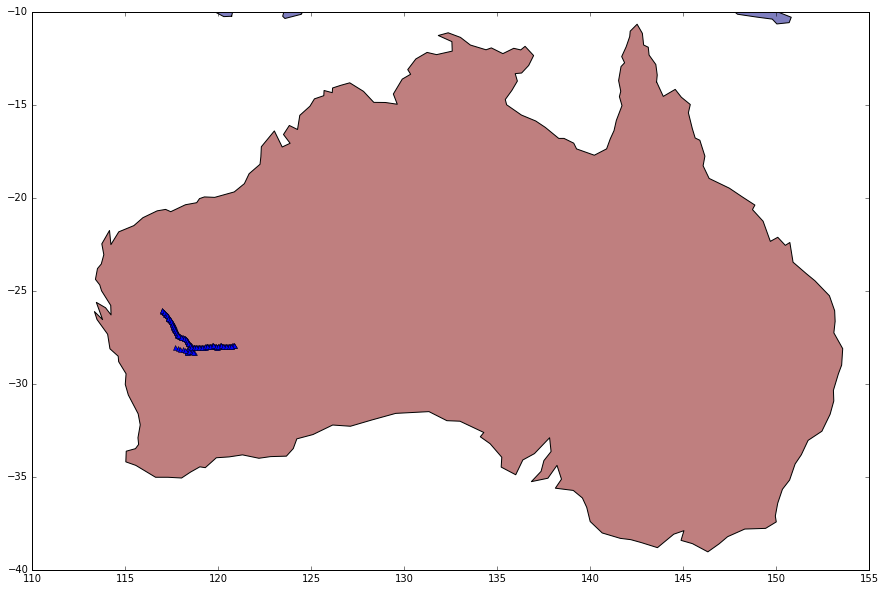

In [41]:
myax=world.plot(alpha=0.5)
#myax.set_xlim([149,150])
myax.set_xlim([110,155])
myax.set_ylim([-40,-10])

rdf.plot(ax=myax, figsize=(10, 6),  marker='^', color='blue', markersize=5);


NameError: name 'shpf3' is not defined

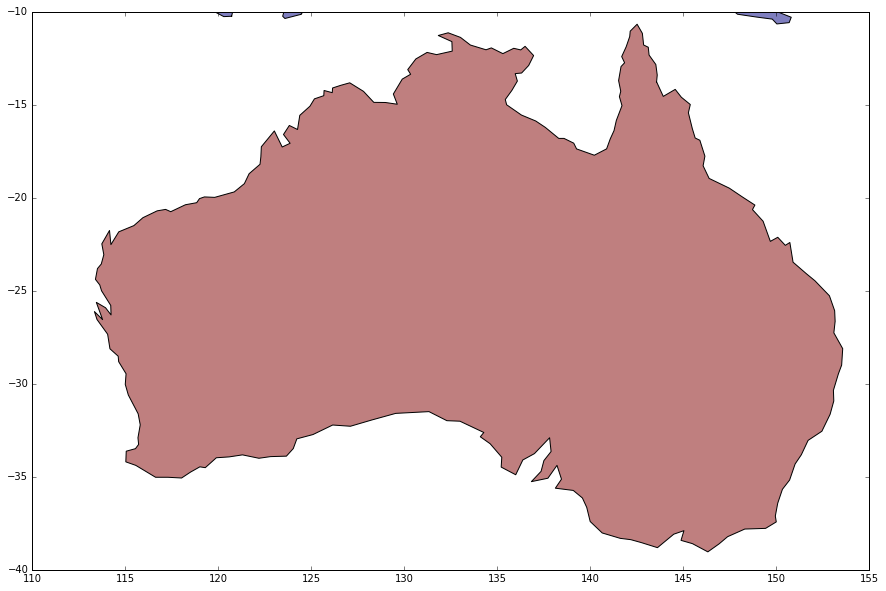

In [42]:
myax=world.plot(alpha=0.5)
#myax.set_xlim([149,150])
myax.set_xlim([110,155])
myax.set_ylim([-40,-10])
shpf3.plot(ax=myax, figsize=(10, 6),  marker='o', color='blue', markersize=5);

In [ ]:
#Phase Tensor shape files and Tipper (Real/Imag) Shape Files

#shpfile=r'E:\MT_shape_files\Tip_1.4286s_WGS84_imag.shp'
#shpfile=r'/Softlab/Data/MT_datasets/728889/Phase_Tensor_Shapes/Tip_2s_WGS84_imag.shp'
shpfile=mt_survey_loc_shp

shpf=gpd.GeoDataFrame.from_file(shpfile)

#shpf['phi_max'].plot(marker='*', markersize=14)

shpf.plot(cmap='OrRd', scheme='quantiles');  #(marker='o', color='red', markersize=5)
print mt_survey_loc_shp
print shpf.shape